# FrozenLake V1
### This notebook attempts to solve the FrozenLake-V1 problem[part of OpenAI's gym environments] using Dynamic Programming & Every-Visit Monte Carlo
### Description of problem: 
### The "frozen lake" is either a 4x4 or 8x8 grid environment, where the agent[starting from top left grid] attempts to reach the goal[G] without falling into any holes[H]. All transition rewards=0, except for transition into terminal state[reward=1]. If agent falls into hole, it restarts from initial starting position[S]

## Part 1: Dynamic Programming 

#### Import modules 

In [1]:
from tqdm import tqdm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import gym

#### Create environment 
#### In this case, we only consider deterministic problem[where action=down will definitely lead to transition to the state below(for example)] in a 8x8 gridworld

We start by creating 3 arrays: \
1) state_values: an array of 64 values(initialised to 0) for recording values for each state \
2) new_state_values: an array of 64 values(initialised to 0) for recording new values for each state \
3) actions: an array of 4 values[0,1,2,3](each representing LEFT,DOWN,RIGHT,UP actions]

delta is the difference between new & old state values(initialised to 0) \
theta is the min threshold for a value update to be allowed \
discount=gamma \
episodes = no. of complete training sequences

In [ ]:
env = gym.make('FrozenLake-v1', desc=None,map_name="8x8", is_slippery=False, new_step_api=True)

observation, info = env.reset(seed=0, return_info=True)
state_values = np.zeros(64)
new_state_values = np.zeros(64)
actions = np.arange(4)
delta, theta, discount, episodes = 0, 0.0001, 0.9, 1000

#### Train agent  

We start by considering every state[64 in total] \
For each state, we create a list(q_values) to store q_value for every state-action pair \
For each action, we pass state & action to env.env.P to obtain a series of transitions \
For each transition, we get prob, next_state, reward, terminal \
We will use prob, next_state & reward to increment that particular state-action pair's value \

Once completed, we calculate delta(absolute difference between old state value & max(q_values) \
If delta exceeds threshold(theta), we then use it as our new state value \
After each complete sweep, we replace state_values with new_state_values

In [ ]:
for episode in tqdm(range(episodes)):
    for state in range(len(state_values)):
        q_values = np.zeros(4)
        for action in range(len(actions)):
            transitions = env.env.P[state][action]
            for transition in transitions:
                prob, next_state, reward, terminal = transition
                q_values[action] += prob*(reward + discount*state_values[next_state])
        delta = np.abs(max(q_values) - state_values[state])
        if delta > theta:
            new_state_values[state] = max(q_values)
    state_values = new_state_values        
print(f"Sweep for {episodes} episodes done")        

#### Optimize policy 

Policy optimization is done after completion of agent training \
Similar steps are followed, with the exception of selecting the index of the action that gives max(q_values) \
If there is a tie, we use np.random.choice to select at random \
Since index is also the action, selected index will be the optimal action for that state \
Finally, update policy for that state using optimal action 

In [ ]:
optimal_policy = np.zeros(64)
for state in range(len(state_values)):
    q_values = np.zeros(4)
    for action in range(len(actions)):
        transitions = env.env.P[state][action]
        for transition in transitions:
            prob, next_state, reward, terminal = transition
            q_values[action] += prob*(reward + discount*state_values[next_state])
    optimal_action = np.random.choice([idx for idx in range(len(q_values)) if q_values[idx] == max(q_values)])
    optimal_policy[state] = optimal_action

Example of state_values, reshaped as 8x8 array

In [ ]:
state_values.reshape(8,8)

#### Rendering 

This is where we observe our trained agent in action \
Notice how our agent is able to find an optimal path to the goal, while avoiding all holes

In [ ]:
env = gym.make('FrozenLake-v1', desc=None,map_name="8x8", is_slippery=False, render_mode='human')
observation, info = env.reset(seed=0, return_info=True)
env.render()
for episode in range(100):
    state=observation
    observation, reward, done, info = env.step(action = int(optimal_policy[state]))
    env.render()
    
    if done:  
        break
        
env.close()         

#### Conclusion 

As demonstrated, the usage of dynamic programming is able to find an optimal solution for this simple 8x8 gridworld problem \
However, do note that DP is seldom used due to it's computational complexity although it is important to understand it's concepts since they will be further developed upon in other methods

## Part 2: Every-Visit Monte Carlo 

Next, we attempt every-visit monte carlo on the same environment \
Logic is as followed:
For each episode, \
1) Calculate action_probability[action_prob]. If it's < epsilon, take exploratory action. Otherwise, act greedily \
2) Pass action to env.step() to obtain next_state & reward \
3) Append [state,action,reward] to episode list \
4) Update state as next_state

Upon termination: \
Initialise return[G]=0 \
To facilitate return calculation for every state-action pair, we work backwards \
Starting from last state-action pair, set it's reward[G[last]]=reward[last] \
2nd-last state-action pair will have G[2nd-last] = reward[2nd-last] + G[last] \
3rd-last state-action pair will have G[3rd-last] = reward[3rd-last] + g[2nd-last] \
And so on...

For each state-action pair visited:
append it's G to returns[(state,action)] \
returns is a dictionary containing all Gs for every state-action pair visited \
Idea is to take average of each returns[(state,action)] as new action-values 

Incremental update: \
Instead of using sum(returns[(state,action)])/len(returns[(state,action)]) for means calculation, \
we can use returns[(s, a)] + (returns[(s, a)][-1] - action_values[s, a])/len(returns[(s, a)]) to get same result faster

New episode: \
After each episode, reset terminate=False, reset env{env.reset()) & reset episode=[] 

Policy update: \
policy list is an array of size (,64), each representing the optimal action for each state \
Loop through each state & take argmax of each state's action_value to get optimal action \
Ties are broken randomly 


In [2]:
env = gym.make('FrozenLake-v1', desc=None,map_name="8x8", is_slippery=False, new_step_api=True)

state, info = env.reset(seed=0, return_info=True)
action_values = np.zeros((64,4))
policy = np.zeros(64)
episodes = 40000
epsilon = 0.01
total_rewards = []
average_rewards = []
terminate = False
returns = {}
episode = []

In [3]:
for i in tqdm(range(episodes)):
    while not terminate:
        action_prob = np.random.uniform()
        if action_prob < epsilon:
            action = env.action_space.sample()
        else:
            action = np.random.choice([idx for idx in range(4) if action_values[state,idx] == max(action_values[state])])
        next_state, reward, terminate, truncated, info = env.step(action)
        episode.append([state,action,reward])
        total_rewards.append(reward)
        state = next_state  
    G = 0
    for i in reversed(range(len(episode))):
        s,a,r = episode[i]
        G += r
        if returns.get((s,a)):
            returns[(s,a)].append(G)
        else:
            returns[(s,a)] = [G]
                

    #action_values[s, a] = sum(returns[(s,a)])/len(returns[(s,a)])
        action_values[s, a] += (returns[(s, a)][-1] - action_values[s, a])/len(returns[(s, a)])
    
    for j in range(len(policy)-1):
        policy[j] = np.random.choice([idx for idx in range(4) if action_values[j,idx] == max(action_values[j])])
        
    state = env.reset() 
    episode = []  
    terminate = False
    
    if i%100==0:
#         print(f"average reward for batch {i%100}: {sum(total_rewards)/len(total_rewards)}")
        average_rewards.append(sum(total_rewards)/len(total_rewards))
        
print(f"agent training for {episodes} episodes done")

100%|██████████| 40000/40000 [31:31<00:00, 21.15it/s]

agent training for 40000 episodes done


#### Plot average rewards over time[calculated for every ith batch] 

Let's calculate average rewards everytime we hit i%100 == 0 & plot it on a graph \
Observe that average rewards are increasing over time

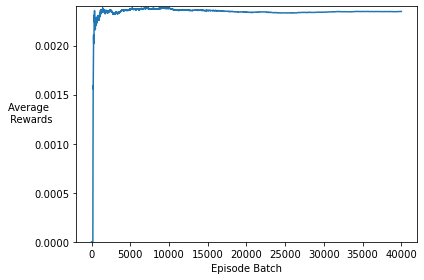

In [4]:
plt.plot(average_rewards)
plt.xlabel("Episode Batch")
plt.ylabel("Average \n Rewards",rotation=0)
plt.ylim(0,round(max(average_rewards),4))
plt.tight_layout()
plt.show()

In [5]:
policy.reshape(8,8)

array([[3., 2., 2., 2., 2., 1., 2., 1.],
       [3., 1., 3., 3., 2., 2., 1., 3.],
       [3., 3., 0., 1., 1., 2., 2., 1.],
       [1., 0., 0., 0., 0., 2., 2., 1.],
       [3., 3., 0., 3., 3., 0., 3., 1.],
       [3., 2., 0., 2., 3., 0., 2., 1.],
       [3., 0., 3., 1., 3., 2., 3., 1.],
       [2., 3., 1., 1., 3., 0., 3., 0.]])

#### Rendering[If needed] 

In [ ]:
env = gym.make('FrozenLake-v1', desc=None,map_name="8x8", is_slippery=False, render_mode='human')
observation, info = env.reset(seed=0, return_info=True)
env.render()
for episode in range(100):
    state=observation
    observation, reward, done, info = env.step(action = int(policy[state]))
    env.render()
    
    if done:  
        break
        
env.close()  

#### Conclusion
As observed from the final policy, every-visit MC does not give a perfect solution with current params \
Draw out the path given by optimal policy on a 8x8 grid to have a clearer picture \
Although most most states have policies pointing in the "right" directions, we observe a few states with incorrect policies[that does not point in the optimal direction] \
With more episodes however, we should be able to correct this issue and achieve a good solution